# Предсказание цен на недвижимость

**Борисочкин Михаил ML-12**

## Задание

Участникам предоставлен набор данных объявлений о продаже недвижимости в некотором волшебном городе N. Задача - предсказать цену недвижимости по содержанию объявления.

In [1]:
from typing import List, Dict
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import numpy as np
import lightgbm as lgb
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## Разведывательный анализ данных

In [2]:
# Загрузка датасета
data = pd.read_csv("data/train.csv")

data.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,560,NaN,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4510000
1,1,2011-1,667,NaN,10,50,2,1,25.0,NaN,...,0,0,0,0,0,0,0,0,0,13231000
2,2,2011-1,90,0.0,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,2008000
3,3,2011-1,94,1.0,3,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,12680000
4,4,2011-1,232,0.0,3,60,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,3335000


In [3]:
# Последние пять строк датасета
data.tail()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
99995,99995,2012-3,401,0.0,5,30,1,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,1697000
99996,99996,2012-3,59,0.0,4,34,1,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,3620000
99997,99997,2012-3,253,NaN,3,52,2,0,5.0,NaN,...,0,0,0,0,0,0,0,0,0,6712000
99998,99998,2012-3,305,1.0,3,181,5,1,5.0,NaN,...,0,0,0,0,0,0,0,0,0,20835000
99999,99999,2012-3,482,0.0,7,57,2,0,5.0,0.0,...,0,0,0,0,0,0,0,0,0,2909000


In [4]:
# Информация о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   date        100000 non-null  object 
 2   street_id   100000 non-null  int64  
 3   build_tech  70265 non-null   float64
 4   floor       100000 non-null  int64  
 5   area        100000 non-null  int64  
 6   rooms       100000 non-null  int64  
 7   balcon      100000 non-null  int64  
 8   metro_dist  95104 non-null   float64
 9   g_lift      70008 non-null   float64
 10  n_photos    100000 non-null  int64  
 11  kw1         100000 non-null  int64  
 12  kw2         100000 non-null  int64  
 13  kw3         100000 non-null  int64  
 14  kw4         100000 non-null  int64  
 15  kw5         100000 non-null  int64  
 16  kw6         100000 non-null  int64  
 17  kw7         100000 non-null  int64  
 18  kw8         100000 non-null  int64  
 19  kw9

В исходном наборе данных 100 000 записей и 25 признаков. По названию признаков были сделаны следующие предположения о том, что они обозначают:

- id — id записи в системе по продаже недвижимости;
- date — дата (месяц и год) публикации объявления;
- street_id — id улицы в городе N, где располагается недвижимость;
- build_tech — ???;
- floor — этаж, на котором располагается недвижимость;
- area — площадь недвижимости в у. е.;
- rooms — количество жилых комнат в недвижимости;
- balcon — количество балконов в квартире;
- metro_dist — расстояние до ближайшей станции метро;
- g_lift — как-то связано с лифтом;
- n_photos — количество фотографий в объявлении о продаже недвижимости;
- kw1 — kw13 — какие-то ключевые слова о недвижимости. Предположительно бинарные;
- price — цена недвижимости. Является целевым признаком.

Также из сводки видно, что в датасете отсутсвуют значения в колонках build_tech, metro_dist и g_lift.

Давайте сразу разделим дату на год и месяц

In [5]:
# Разделение даты на год и месяц
data["date"] = pd.to_datetime(data["date"], format="%Y-%m")
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month

data = data.drop(columns=["date"])

# Перемещение колонок
year = data.pop("year")
data.insert(1, "year", year)
month = data.pop("month")
data.insert(2, "month", month)

Проверим статистические показатели признаков и их распределения.

In [6]:
# Статистические показатели данных
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,100000.0,4.999950e+04,2.886766e+04,0.0,24999.75,49999.5,74999.25,99999.0
year,100000.0,2.011332e+03,4.707726e-01,2011.0,2011.00,2011.0,2012.00,2012.0
month,100000.0,6.510570e+00,3.862589e+00,1.0,3.00,7.0,10.00,12.0
street_id,100000.0,3.344793e+02,1.940048e+02,0.0,167.00,334.0,501.00,671.0
build_tech,70265.0,5.298370e-01,5.736453e-01,0.0,0.00,0.0,1.00,2.0
floor,100000.0,5.267680e+00,3.905558e+00,1.0,2.00,4.0,7.00,25.0
area,100000.0,5.225343e+01,1.779250e+01,29.0,40.00,52.0,60.00,217.0
rooms,100000.0,2.118680e+00,8.296879e-01,1.0,1.00,2.0,3.00,6.0
balcon,100000.0,3.967400e-01,5.476316e-01,0.0,0.00,0.0,1.00,2.0
metro_dist,95104.0,2.215443e+01,8.286241e+00,0.0,15.00,25.0,30.00,30.0


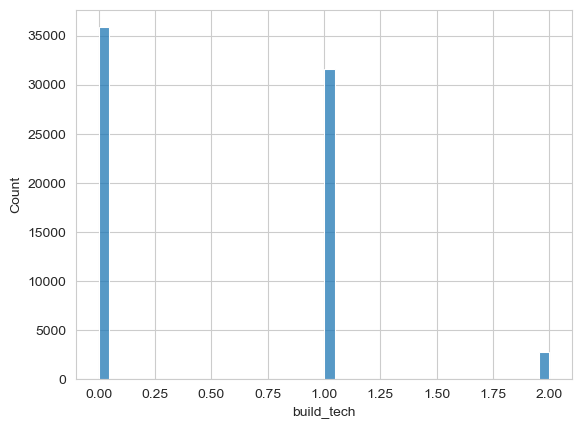

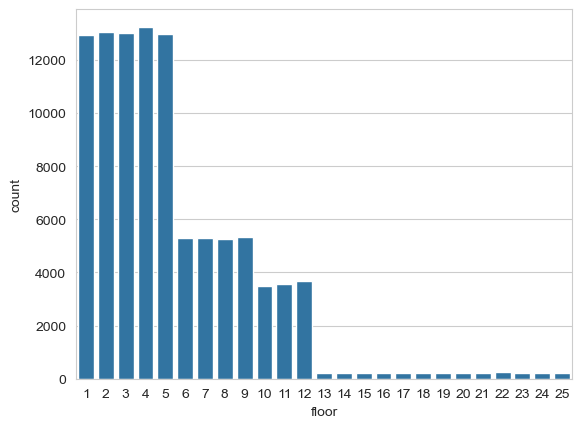

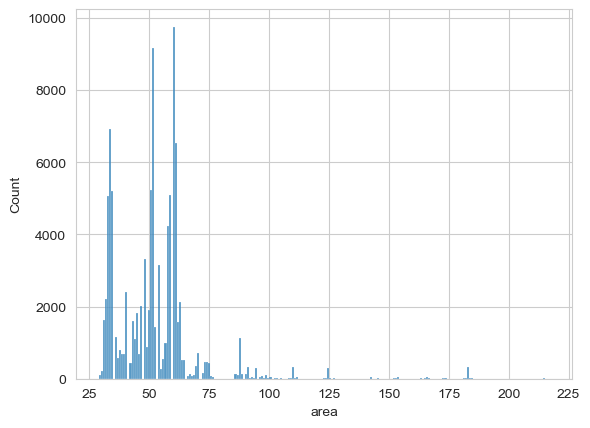

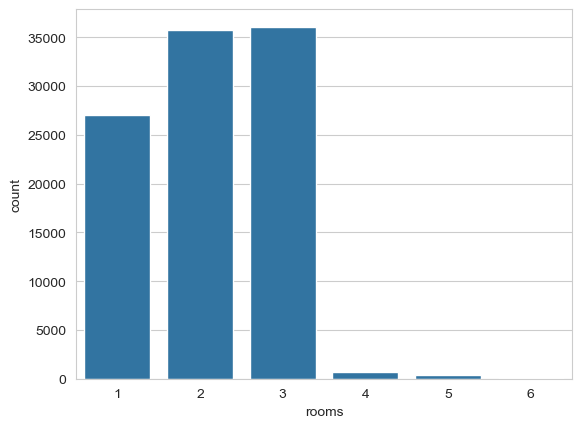

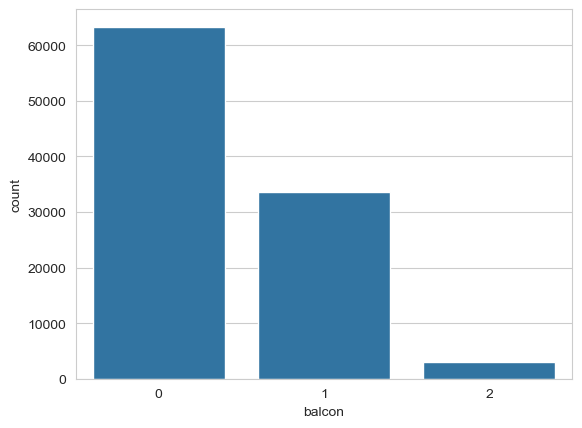

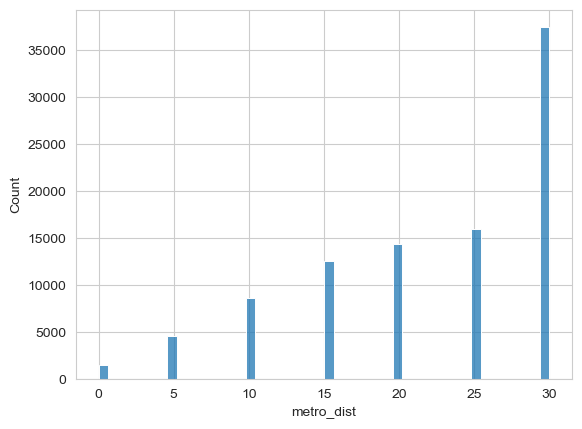

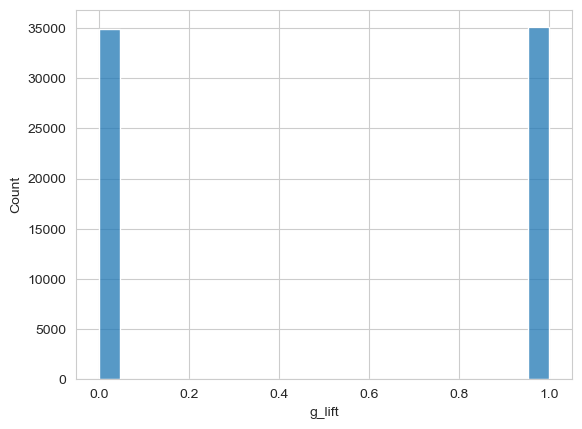

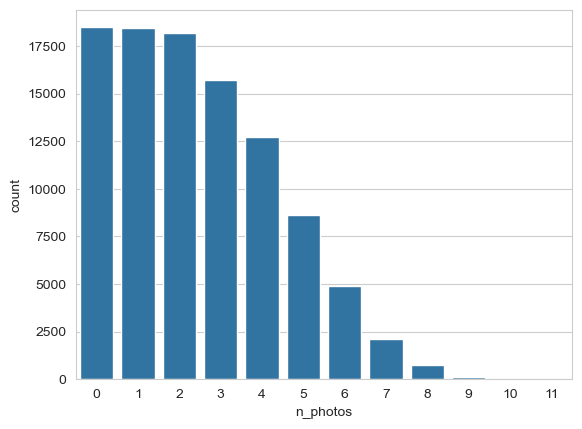

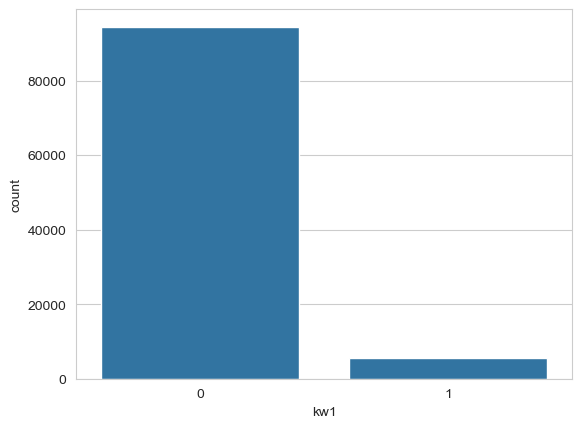

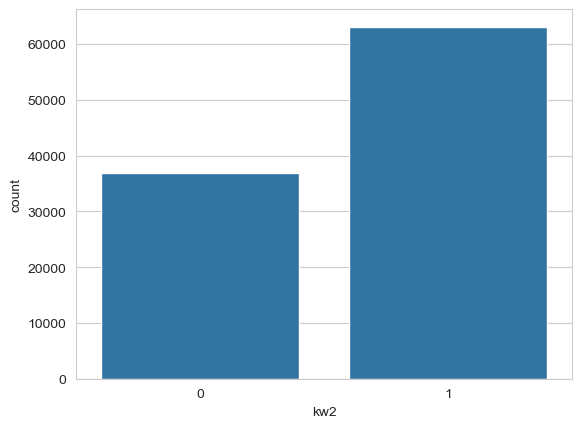

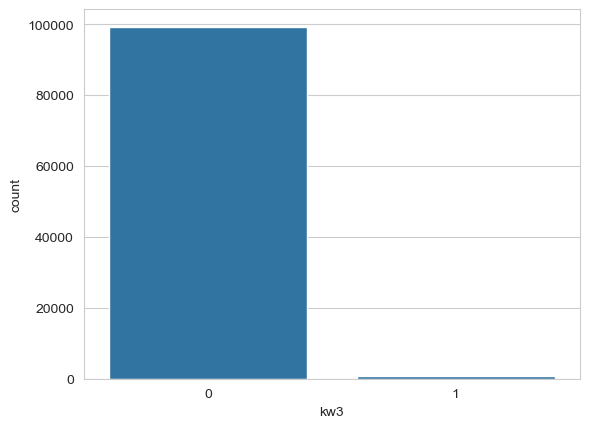

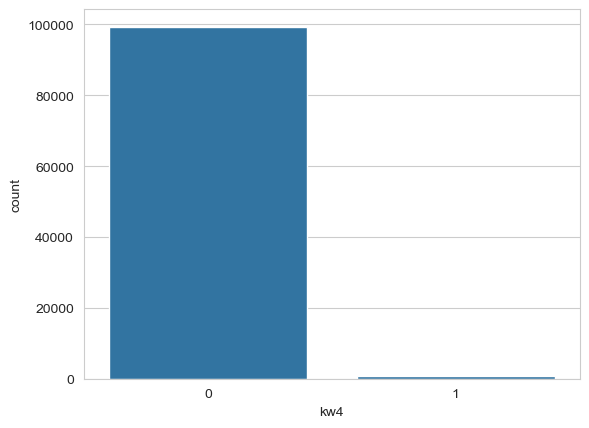

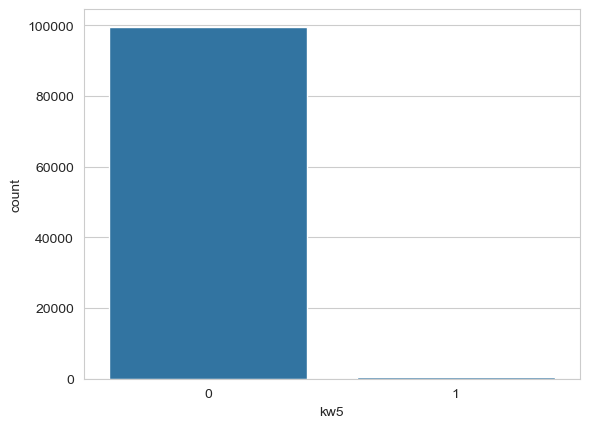

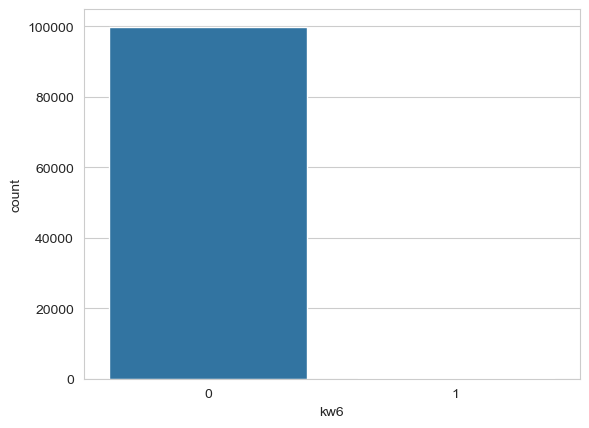

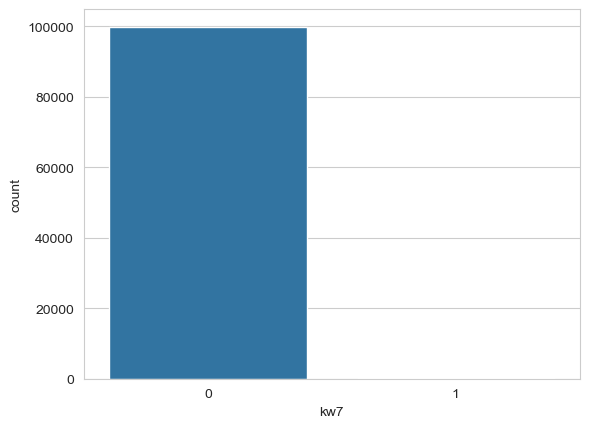

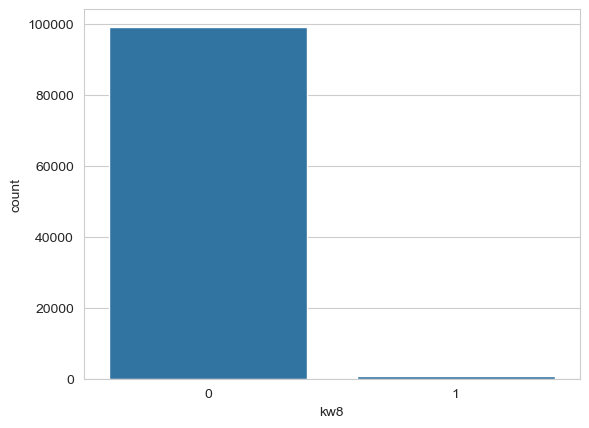

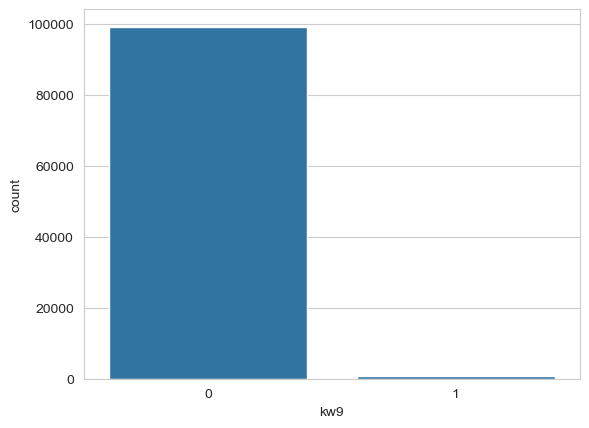

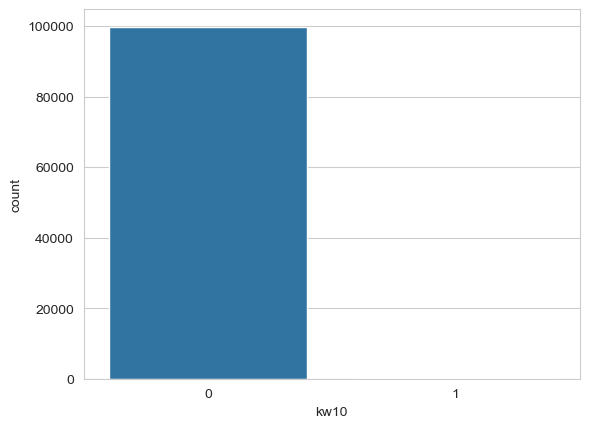

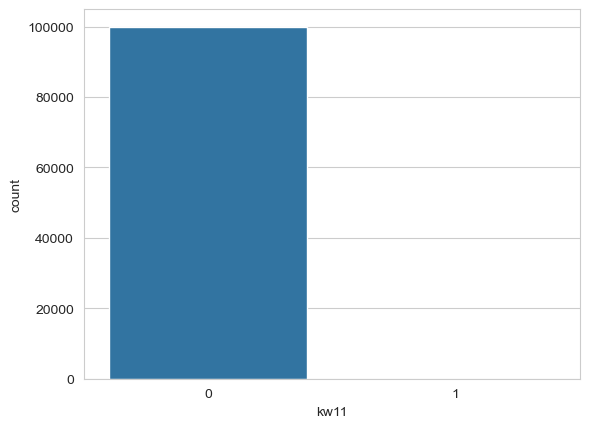

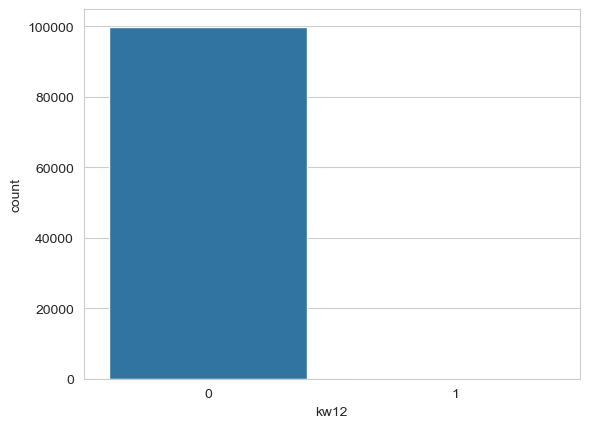

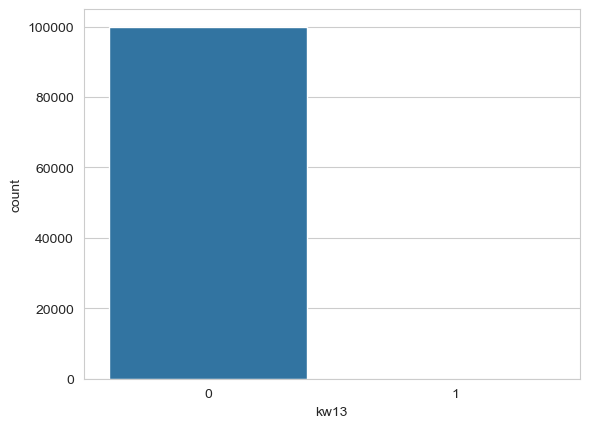

In [7]:
# Распределение нецелевых признаков (кроме года и месяца)
for column, dtype in zip(data.columns[4:-1], data.dtypes[4:-1]):
    if column == "area":
        sns.histplot(data, x=column)
        plt.show()
        continue

    if dtype == "int64":
        sns.countplot(data, x=column)
    elif dtype == "float64":
        sns.histplot(data, x=column)
    plt.show()

После анализа распределений получаем следующие результаты:
- Признаки kw1-kw13 действительно бинарные;
- Признаки build_tech и g_lift имеют определённое множество возможных значений, хотя и имеют тип данных с плавающеей запятой. Скорее всего, это закодированные категориальные признаки;
- Признак metro_dist тоже принимает только ограниченное множество дискретных значений, хотя и представлен, как float. Также, судя по значениям, под дистанцией до метро подразумевается не расстояние, а время, за которое до него можно дойти;
- Больше всего квартир продают в пятиэтажках, судя по распределению этажей.

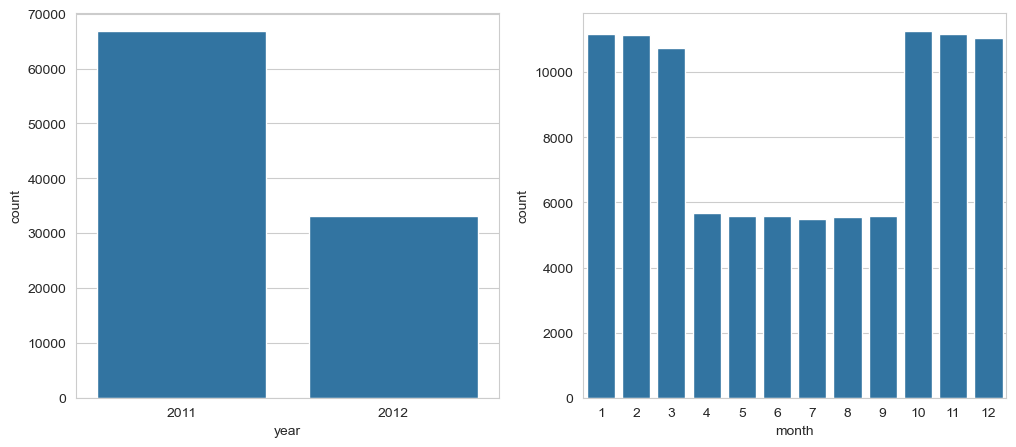

In [8]:
# Распределение года и месяца
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(data, x="year", ax=ax[0])
sns.countplot(data, x="month", ax=ax[1])
plt.show()

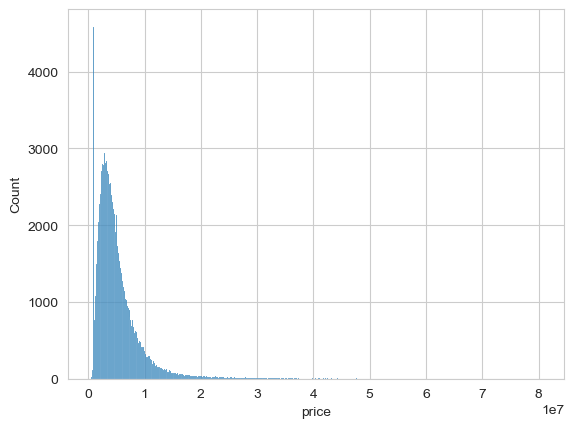

In [9]:
# Распределение целевого признака
sns.histplot(data=data, x="price")
plt.show()

На распределении цен жилья виден большой "хвост". Непонятно это выбросы или такая ситуация возможно. Необходимо проконсультироваться с экспертом. Однако ввиду отсутствия такового придётся рассматривать оба варианта.

Также виден "рог" из предложений недвижимости примерно за миллион у. е. В данном случае также стоит посоветоваться с экспертом.

In [10]:
# Недвижимость с максимальной стоимостью
data[data["price"] == data["price"].max()]

,id,year,month,street_id,build_tech,floor,area,rooms,balcon,metro_dist,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
51128,51128,2011,7,186,1.0,5,154,4,0,30.0,...,0,0,0,0,0,0,0,0,0,80548000


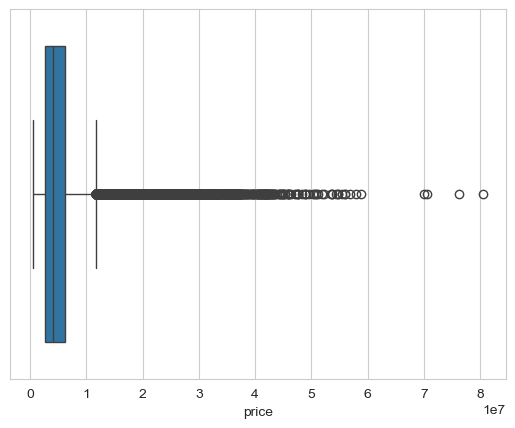

In [11]:
# Ящик с усами для цены
sns.boxplot(data, x="price")
plt.show()

На ящике с усами потенциальные выбросы очень хорошо видно.

Теперь оценил корреляцию между признаками.

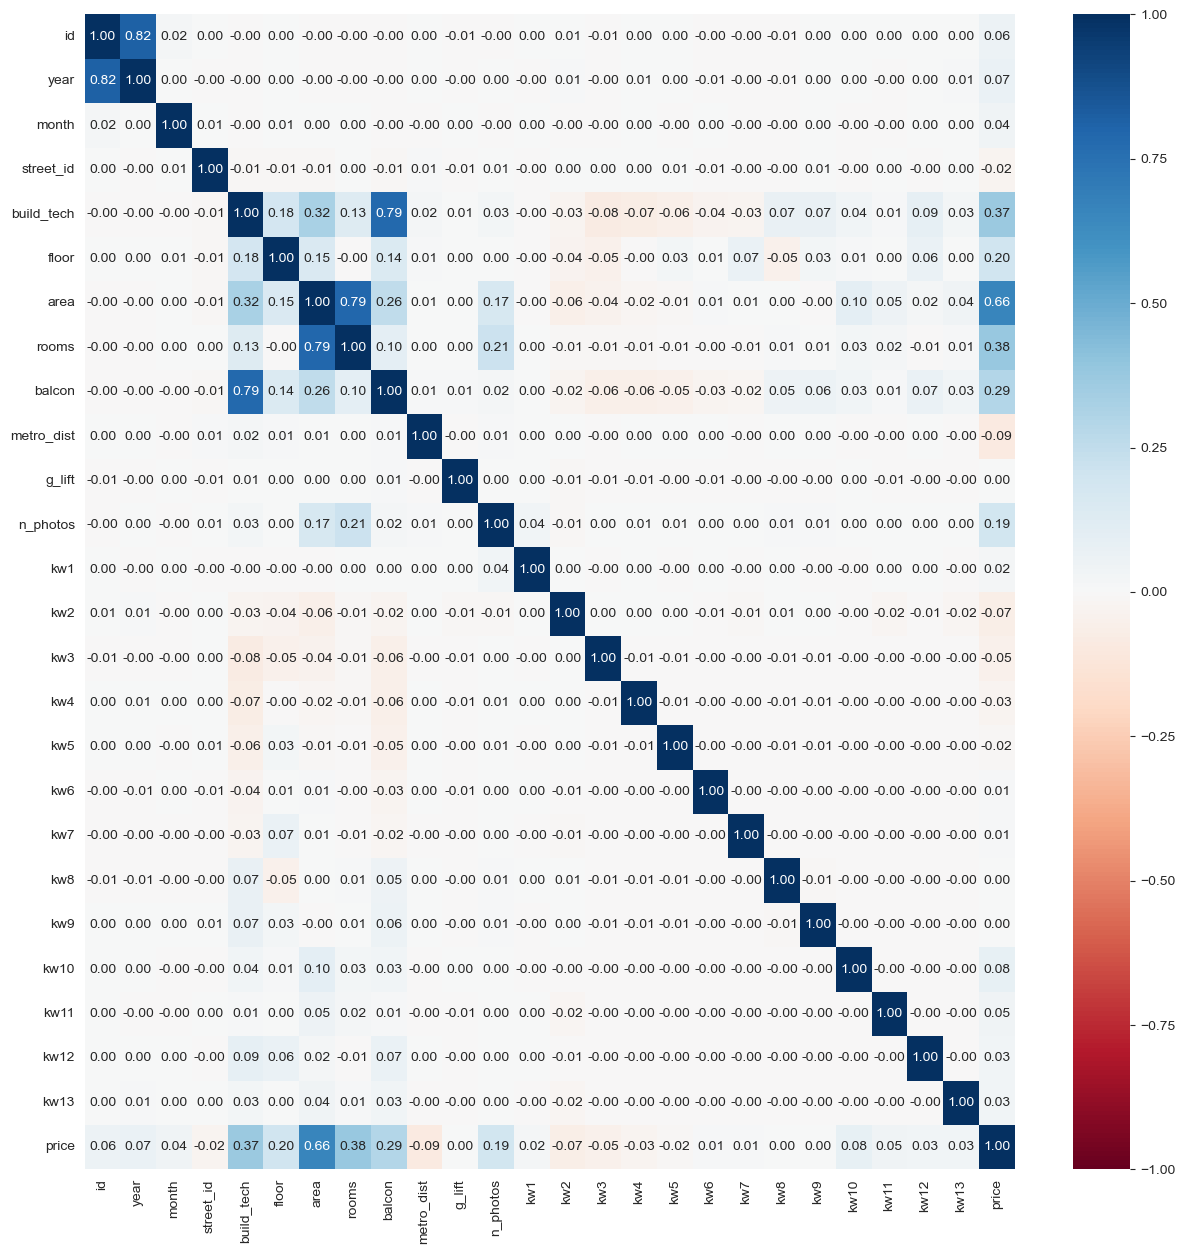

In [12]:
# Тепловая карта корреляционной матрицы
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    data.corr(numeric_only=True),
    annot=True,
    vmin=-1,
    vmax=1,
    ax=ax,
    fmt=".2f",
    cmap="RdBu",
)
plt.show()

Сильнее всего с целевым признаком коррелируют признаки area, rooms, build_tech, balcon, floor, n_photos. Также build_tech и balcon имеют сильную зависимость между собой, как и area и rooms.

Дополнительно, можно заметить зависимость между годом и id. Её, предположительно, можно объяснить тем, что id представлен в виде автоинкремента и как и год он со временем только увеличивается.

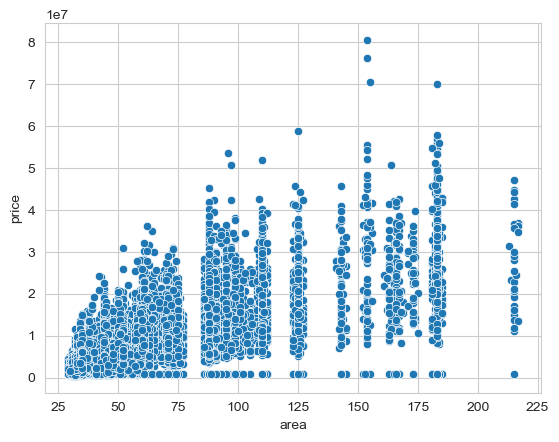

In [13]:
# Диаграмма рассеивания между признаками area и price
sns.scatterplot(data=data, x="area", y="price")
plt.show()

## Предобработка данных

Нам необходимо как минимум заполнить пропуски в данных. Дополнительно очистим целевой признак от выбросов и определимся с набором признаков для обучения.

### Очистка от выбросов

Удалим выбросы в цене и посмотрим как поменяется корреляция между признаками

In [14]:
# Очистка столбца price
Q1, Q3 = data["price"].quantile([0.25, 0.75])
IQR = Q3 - Q1
min_limit = Q1 - 1.5 * IQR
max_limit = Q3 + 1.5 * IQR

data_without_outliers = data[
    (data["price"] > min_limit) & (data["price"] < max_limit)
].copy()
data_without_outliers.shape

(94443, 26)

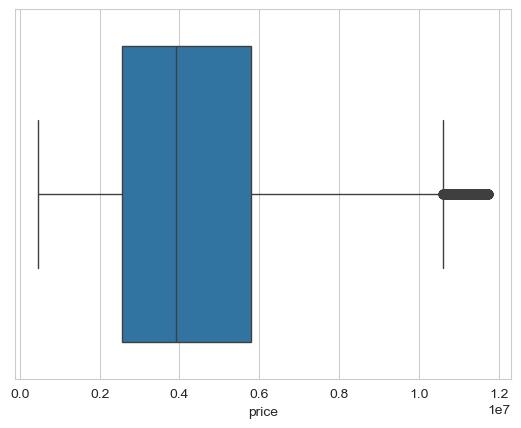

In [15]:
# Ящик с усами для столбца price
sns.boxplot(x=data_without_outliers["price"])
plt.show()

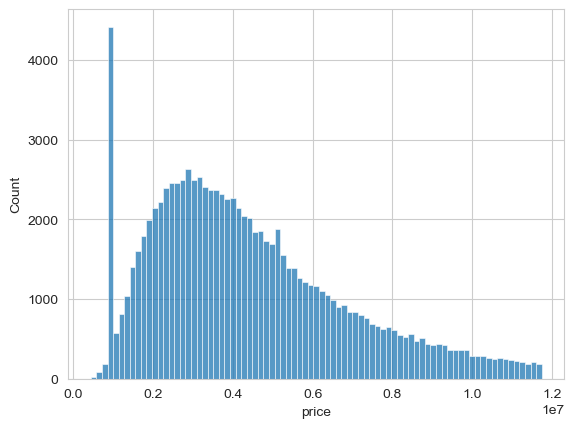

In [16]:
# Распределение целевого признака
sns.histplot(data=data_without_outliers, x="price")
plt.show()

Как мы видим "хвост" исчез. Однако остался "рог" из миллионников.

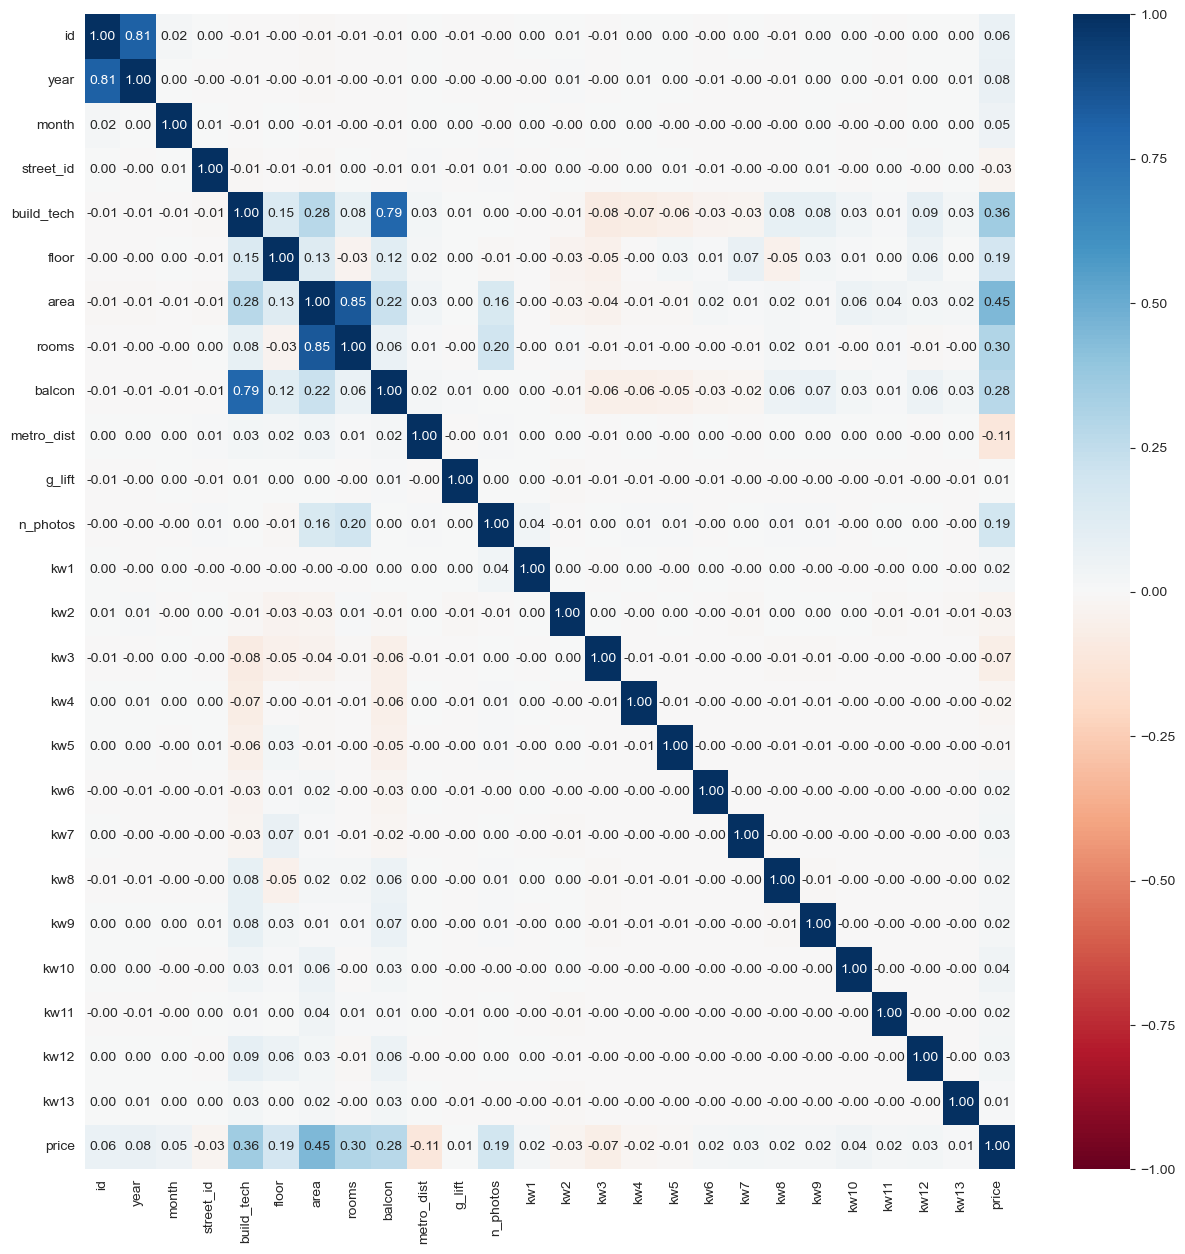

In [17]:
# Тепловая карта корреляционной матрицы
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    data_without_outliers.corr(numeric_only=True),
    annot=True,
    vmin=-1,
    vmax=1,
    ax=ax,
    fmt=".2f",
    cmap="RdBu",
)
plt.show()

После удаления выбросов корреляция между price и area уменьшилась.

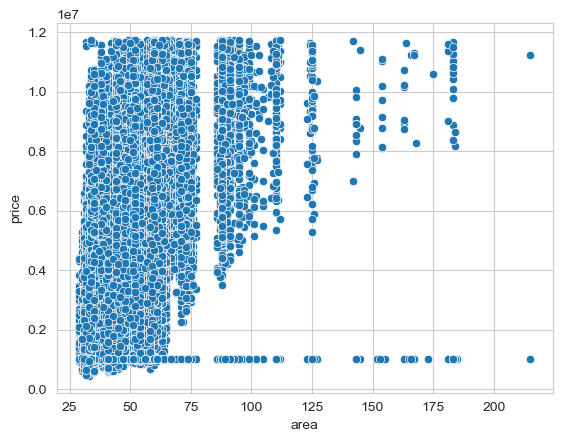

In [18]:
sns.scatterplot(data=data_without_outliers, x="area", y="price")
plt.show()

### Заполнение пропусков

Пропуски присутствуют в трёх колонках: build_tech, metro_dist и g_lift.

Колонку build_tech заполним с помощью метода ближайших соседей, используя [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html), так как у нас есть несколько признаков, которые неплохо с ним коррелируют.

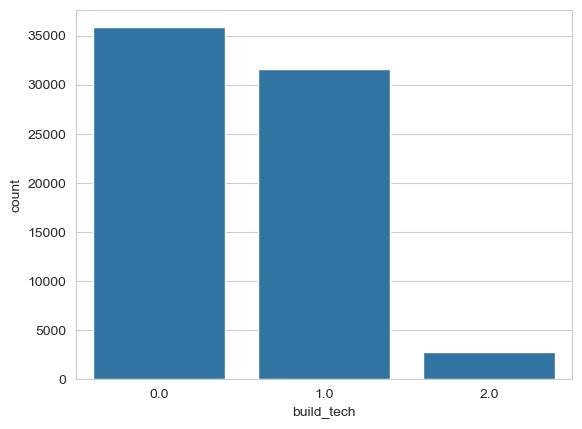

In [19]:
# Распределение признака до заполнения пропусков
sns.countplot(data=data, x="build_tech")
plt.show()

In [20]:
data_preprocessed = data.copy()

imputer = KNNImputer()
data_for_imputer = data[["build_tech", "floor", "area", "rooms", "balcon"]].copy()
raw_imputation = imputer.fit_transform(data_for_imputer)

del data_for_imputer

data_preprocessed["build_tech"] = raw_imputation[:, 0].round().astype("int64")

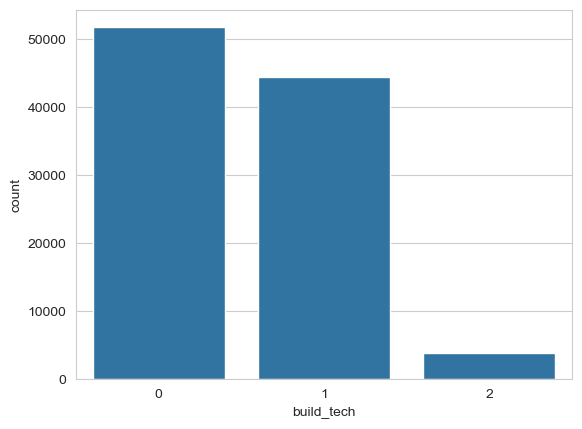

In [21]:
# Распределение признака после заполнения пропусков
sns.countplot(data=data_preprocessed, x="build_tech")
plt.show()

Аналогичную операцию проведём для набора данных без выбросов.

In [22]:
data_preprocessed_without_outliers = data_without_outliers.copy()

imputer = KNNImputer()
data_for_imputer = data_without_outliers[
    ["build_tech", "floor", "area", "rooms", "balcon"]
].copy()
raw_imputation = imputer.fit_transform(data_for_imputer)

del data_for_imputer

data_preprocessed_without_outliers["build_tech"] = (
    raw_imputation[:, 0].round().astype("int64")
)

Теперь заполним metro_dist. Так как признаков имеющих хорошую корреляцию с данным нет и пропусков относительно немного, то заполним его пропуски медианой.

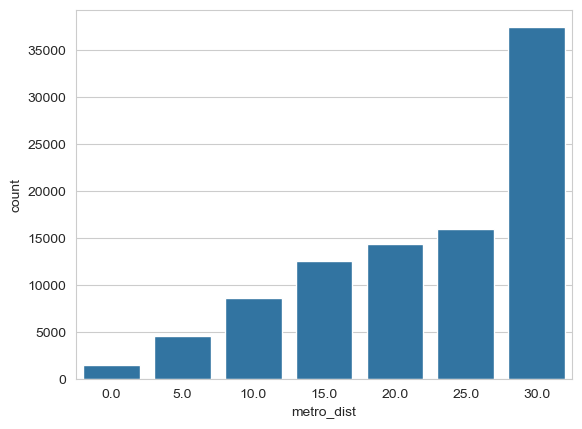

In [23]:
# Распределение признака до заполнения пропусков
sns.countplot(data=data, x="metro_dist")
plt.show()

In [24]:
simple_imputer = SimpleImputer(strategy="median")
data_preprocessed["metro_dist"] = simple_imputer.fit_transform(
    data_preprocessed[["metro_dist"]]
).astype("int64")

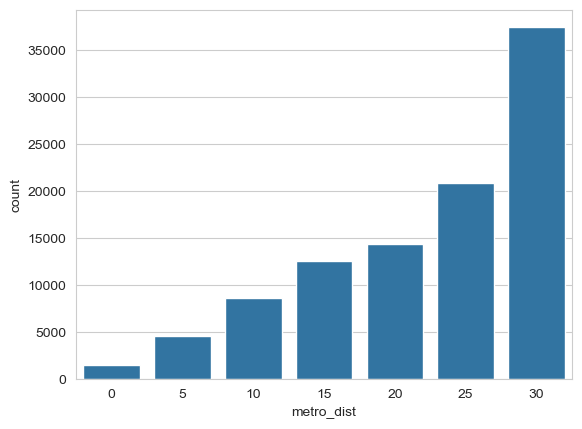

In [25]:
# Распределение признака после заполнения пропусков
sns.countplot(data=data_preprocessed, x="metro_dist")
plt.show()

Аналогично для датасета с выбросами.

In [26]:
data_preprocessed_without_outliers["metro_dist"] = simple_imputer.fit_transform(
    data_preprocessed_without_outliers[["metro_dist"]]
).astype("int64")

Остался только столбец g_lift. С ним не всё так однозначно. Сначала посмотрим на расределение его значений.

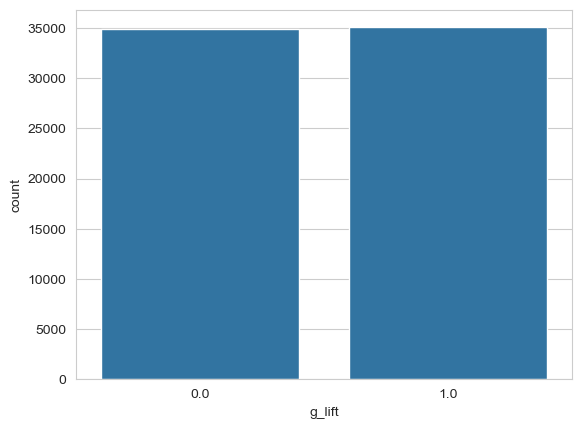

In [27]:
# Распределение признака до заполнения пропусков
sns.countplot(data=data, x="g_lift")
plt.show()

Имеющиеся значения признак g_lift, который предположительно отвечает за наличие грузового лифта в доме, распределены одинаково. Приравнивание пропущенных значений к какому-либо из этих признаков увеличит количество элементов с ним в два раза, что вызовет перекос в распределении. Поэтому я предлагаю добавить новое значение: "неизвестно". Так как значения уже закодированы, то "неизвестно" станет двойкой.

In [28]:
simple_imputer_constant = SimpleImputer(strategy="constant", fill_value=2)
data_preprocessed["g_lift"] = simple_imputer_constant.fit_transform(
    data_preprocessed[["g_lift"]]
).astype("int64")

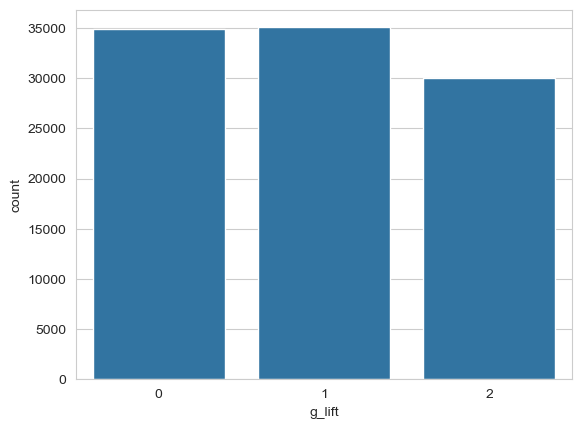

In [29]:
# Распределение признака после заполнения пропусков
sns.countplot(data=data_preprocessed, x="g_lift")
plt.show()

Проводим аналогичные действия для набора данных без выбросов.

In [30]:
data_preprocessed_without_outliers["g_lift"] = simple_imputer_constant.fit_transform(
    data_preprocessed_without_outliers[["g_lift"]]
).astype("int64")

### Выбор признаков

На основе корреляции выделим два набора данных, на которых мы будем обучать наши модели:

1. Набор данных, в котором присутствуют только признаки самой квартиры, которые сильнее всего коррелируют с целевым: build_tech, floor, area, rooms, balcon, n_photos;
2. Набор данных со всеми признаками, кроме id, который является синтетическим ключом и не несёт полезной информации.


In [31]:
# Датасеты для обучения
data_preprocessed_min = data_preprocessed[
    ["build_tech", "floor", "area", "rooms", "balcon", "n_photos", "price"]
]
data_preprocessed = data_preprocessed.drop(columns=["id"])

data_preprocessed_without_outliers_min = data_preprocessed_without_outliers[
    ["build_tech", "floor", "area", "rooms", "balcon", "n_photos", "price"]
]
data_preprocessed_without_outliers = data_preprocessed_without_outliers.drop(
    columns=["id"]
)

In [32]:
def preprocess(
    df: pd.DataFrame, small: bool = False, without_outliers: bool = False
) -> pd.DataFrame:
    """Функция предобработки датасета
    Parameters
    ----------
    df : pandas.DataFrame
        Датасет для предобработки
    small : bool
        Флаг необходимости маленького датасета
    without_outliers : bool
        Флаг необходимости очистки от выбросов

    Returns
    -------
    preprocessed_df : pandas.DataFrame
            Предобработанный датасет
    """
    preprocessed_df = df.copy()

    # Разделение даты на год и месяц
    preprocessed_df["date"] = pd.to_datetime(preprocessed_df["date"], format="%Y-%m")
    preprocessed_df["year"] = preprocessed_df["date"].dt.year
    preprocessed_df["month"] = preprocessed_df["date"].dt.month

    preprocessed_df = preprocessed_df.drop(columns=["date"])

    # Перемещение колонок
    year = preprocessed_df.pop("year")
    preprocessed_df.insert(1, "year", year)
    month = preprocessed_df.pop("month")
    preprocessed_df.insert(2, "month", month)

    # Очистка от выбросов, если есть необходимость
    if without_outliers:
        Q1, Q3 = preprocessed_df["price"].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        min_limit = Q1 - 1.5 * IQR
        max_limit = Q3 + 1.5 * IQR
        preprocessed_df = preprocessed_df[
            (preprocessed_df["price"] > min_limit)
            & (preprocessed_df["price"] < max_limit)
        ]

    # Вставка пропущенных значений
    knn_imputer = KNNImputer()
    data_for_imputer = preprocessed_df[
        ["build_tech", "floor", "area", "rooms", "balcon"]
    ].copy()
    raw_imputation = knn_imputer.fit_transform(data_for_imputer)
    del data_for_imputer
    preprocessed_df["build_tech"] = raw_imputation[:, 0].round().astype("int64")

    simple_imputer_median = SimpleImputer(strategy="median")
    preprocessed_df["metro_dist"] = simple_imputer_median.fit_transform(
        preprocessed_df[["metro_dist"]]
    ).astype("int64")

    simple_imputer_constant = SimpleImputer(strategy="constant", fill_value=2)
    preprocessed_df["g_lift"] = simple_imputer_constant.fit_transform(
        preprocessed_df[["g_lift"]]
    ).astype("int64")

    # Возвращаем маленький или большой датасет
    return (
        preprocessed_df[
            ["build_tech", "floor", "area", "rooms", "balcon", "n_photos", "price"]
        ]
        if small
        else preprocessed_df.drop(columns=["id"])
    )

## Обучение модели

In [33]:
def fit_predict_score(data: pd.DataFrame, model) -> Dict:
    """Функция для обучения и оценки качества моделей из scikit-learn
    Parameters
    ----------
    data : pandas.DataFrame
        Данные для обучения и тестирования
    model
        Модель машинного обучения

    Returns
    -------
     score : Dict
        MAE и R2
    """
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop(columns=["price"]), data["price"], test_size=0.1, random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {"MAE": mean_absolute_error(y_test, y_pred), "R2": r2_score(y_test, y_pred)}

In [34]:
def plot_results(results_list: List, names: List) -> None:
    """Функция вывогда столбчатых диаграмм с метриками качества регрессии
    Parameters
    ----------
    results_list : List
        Список словарей метрик
    names : List
        Название датасетов/моделей
    Returns
        None
    -------
    """
    _, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)

    MAE_list = [item["MAE"] for item in results_list]
    R2_list = [item["R2"] for item in results_list]

    sns.barplot(x=names, y=MAE_list, hue=names, ax=ax[0])
    ax[0].set_title("MAE")
    sns.barplot(x=names, y=R2_list, hue=names, ax=ax[1])
    ax[1].set_title("R2")

    plt.show()

In [35]:
datasets = ["min without outliers", "min", "full without outliers", "full"]
models = [
    "Линейная\nрегрессия",
    "Дерево\nрешений",
    "Случайный\nлес",
    "Градиентный\nбустинг",
    "LightGBM",
]
results_list = []

### Линейная регрессия

In [36]:
lr_reg = Pipeline([("Scaler", MinMaxScaler()), ("Linear", LinearRegression())])

In [37]:
%%time
# Обучение на маленьком датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers_min, lr_reg))
results_list[-1]

CPU times: total: 0 ns
Wall time: 36.7 ms


{'MAE': 1555961.8397044344, 'R2': 0.2952125494232466}

In [38]:
%%time
# Обучение на маленьком датасете
results_list.append(fit_predict_score(data_preprocessed_min, lr_reg))
results_list[-1]

CPU times: total: 172 ms
Wall time: 37 ms


{'MAE': 1914282.0061709594, 'R2': 0.5262749108680844}

In [39]:
%%time
# Обучение на большом датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers, lr_reg))
results_list[-1]

CPU times: total: 422 ms
Wall time: 111 ms


{'MAE': 1513190.018919525, 'R2': 0.32325796627758263}

In [40]:
%%time
# Обучение на большом датасете
results_list.append(fit_predict_score(data_preprocessed, lr_reg))
results_list[-1]

CPU times: total: 172 ms
Wall time: 116 ms


{'MAE': 1861320.8162595567, 'R2': 0.5441927371036172}

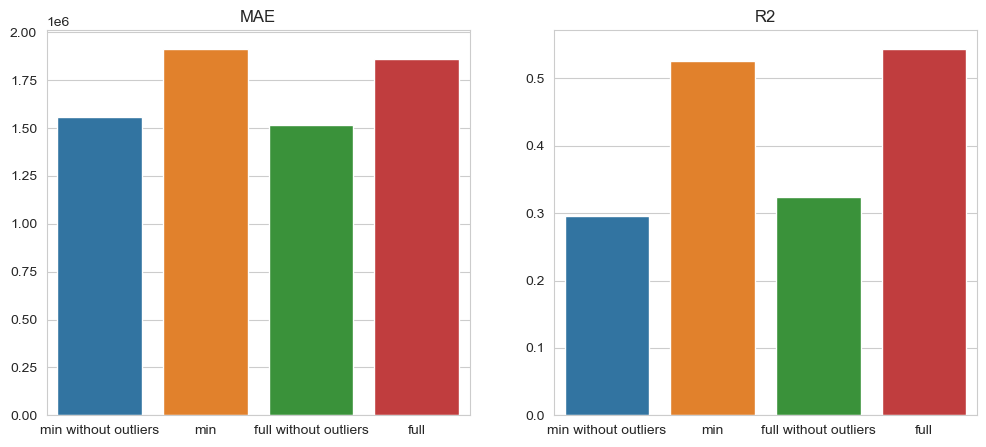

In [41]:
# Сравнение результатов на разных датасетах
plot_results(results_list, datasets)

### Решающее дерево

In [42]:
dt_reg = DecisionTreeRegressor(max_depth=8, random_state=42)

In [43]:
%%time
# Обучение на маленьком датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers_min, dt_reg))
results_list[-1]

CPU times: total: 62.5 ms
Wall time: 79.5 ms


{'MAE': 1483194.7676383092, 'R2': 0.3522680979098912}

In [44]:
%%time
# Обучение на маленьком датасете
results_list.append(fit_predict_score(data_preprocessed_min, dt_reg))
results_list[-1]

CPU times: total: 46.9 ms
Wall time: 93.1 ms


{'MAE': 1892906.5979139209, 'R2': 0.5206770976671184}

In [45]:
%%time
# Обучение на большом датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers, dt_reg))
results_list[-1]

CPU times: total: 141 ms
Wall time: 251 ms


{'MAE': 1466377.548423182, 'R2': 0.36611411395224025}

In [46]:
%%time
# Обучение на большом датасете
results_list.append(fit_predict_score(data_preprocessed, lr_reg))
results_list[-1]

CPU times: total: 156 ms
Wall time: 111 ms


{'MAE': 1861320.8162595567, 'R2': 0.5441927371036172}

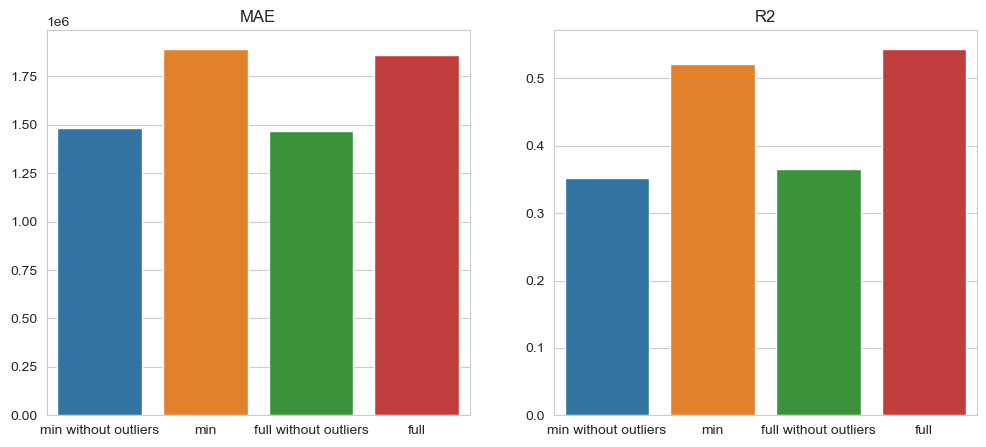

In [47]:
# Сравнение результатов на разных датасетах
plot_results(results_list[4:], datasets)

In [48]:
# Важность признаков в дереве
pd.DataFrame(
    {"feature": dt_reg.feature_names_in_, "importance": dt_reg.feature_importances_}
).sort_values(by="importance", ascending=False)

,feature,importance
5,area,0.660888
3,build_tech,0.125054
10,n_photos,0.064629
6,rooms,0.054464
8,metro_dist,0.034400
2,street_id,0.027679
4,floor,0.018195
0,year,0.009288
1,month,0.003360
9,g_lift,0.000908


### Случайный лес

In [49]:
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)

In [50]:
%%time
# Обучение на маленьком датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers_min, rf_reg))
results_list[-1]

CPU times: total: 9.42 s
Wall time: 14.4 s


{'MAE': 1532348.3626289251, 'R2': 0.30196909333183797}

In [51]:
%%time
# Обучение на маленьком датасете
results_list.append(fit_predict_score(data_preprocessed_min, rf_reg))
results_list[-1]

CPU times: total: 9.7 s
Wall time: 16.4 s


{'MAE': 1968542.7468009107, 'R2': 0.4619816826514138}

In [52]:
%%time
# Обучение на большом датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers, rf_reg))
results_list[-1]

CPU times: total: 46.6 s
Wall time: 1min 15s


{'MAE': 1342867.2194597796, 'R2': 0.4463464480006186}

In [53]:
%%time
# Обучение на большом датасете
results_list.append(fit_predict_score(data_preprocessed, rf_reg))
results_list[-1]

CPU times: total: 51.2 s
Wall time: 1min 24s


{'MAE': 1669593.200922222, 'R2': 0.6217320641593438}

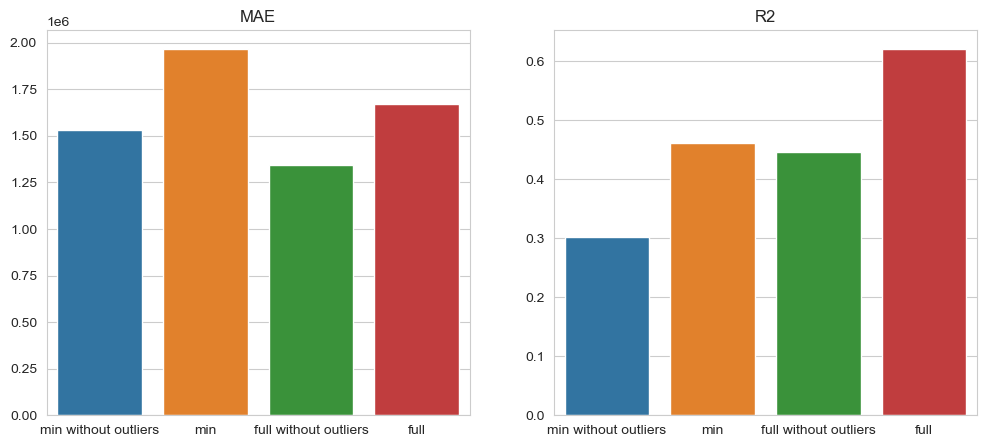

In [54]:
plot_results(results_list[8:], datasets)

In [55]:
# Важность признаков в случайном лесе
pd.DataFrame(
    {"feature": rf_reg.feature_names_in_, "importance": rf_reg.feature_importances_}
).sort_values(by="importance", ascending=False)

,feature,importance
5,area,0.516894
2,street_id,0.173868
4,floor,0.054960
10,n_photos,0.052633
1,month,0.049411
8,metro_dist,0.037166
3,build_tech,0.029764
9,g_lift,0.021615
6,rooms,0.017171
12,kw2,0.012327


### Градиентный бустинг

In [56]:
gb_reg = GradientBoostingRegressor(random_state=42)

In [57]:
%%time
# Обучение на маленьком датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers_min, gb_reg))
results_list[-1]

CPU times: total: 1.97 s
Wall time: 3.46 s


{'MAE': 1481058.3273803287, 'R2': 0.3586453611688474}

In [58]:
%%time
# Обучение на маленьком датасете
results_list.append(fit_predict_score(data_preprocessed_min, gb_reg))
results_list[-1]

CPU times: total: 2.27 s
Wall time: 3.71 s


{'MAE': 1859043.8384263557, 'R2': 0.5443401681189913}

In [59]:
%%time
# Обучение на большом датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers, gb_reg))
results_list[-1]

CPU times: total: 4.89 s
Wall time: 8.94 s


{'MAE': 1401321.6732169907, 'R2': 0.41228043224955735}

In [60]:
%%time
# Обучение на большом датасете
results_list.append(fit_predict_score(data_preprocessed, gb_reg))
results_list[-1]

CPU times: total: 5.8 s
Wall time: 10.1 s


{'MAE': 1745828.5711109852, 'R2': 0.5959675048972093}

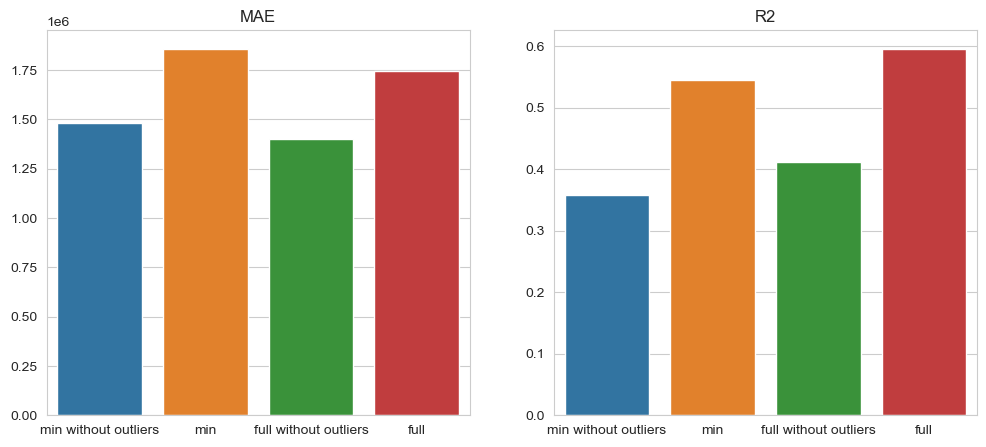

In [61]:
# Сравнение результатов на разных датасетах
plot_results(results_list[12:], datasets)

In [62]:
# Важность признаков в градиентном бустинге
pd.DataFrame(
    {"feature": gb_reg.feature_names_in_, "importance": gb_reg.feature_importances_}
).sort_values(by="importance", ascending=False)

,feature,importance
5,area,0.774418
3,build_tech,0.050301
2,street_id,0.049901
6,rooms,0.044656
10,n_photos,0.034881
8,metro_dist,0.020133
4,floor,0.010818
0,year,0.008299
1,month,0.005771
20,kw10,0.000310


### Другой градиентный бустинг (LightGBM)

#### Scikit-learn API

In [63]:
gbm = lgb.LGBMRegressor(random_state=42)

In [64]:
%%time
# Обучение на маленьком датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers_min, gbm))
results_list[-1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 84998, number of used features: 6
[LightGBM] [Info] Start training from score 4392479.928940
CPU times: total: 828 ms
Wall time: 285 ms


{'MAE': 1470974.3145042842, 'R2': 0.36241057169118174}

In [65]:
%%time
# Обучение на маленьком датасете
results_list.append(fit_predict_score(data_preprocessed_min, gbm))
results_list[-1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 6
[LightGBM] [Info] Start training from score 5132266.388889
CPU times: total: 562 ms
Wall time: 196 ms


{'MAE': 1851663.9019536339, 'R2': 0.5423752733567422}

In [66]:
%%time
# Обучение на большом датасете без выбросов
results_list.append(fit_predict_score(data_preprocessed_without_outliers, gbm))
results_list[-1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 84998, number of used features: 22
[LightGBM] [Info] Start training from score 4392479.928940
CPU times: total: 1.27 s
Wall time: 329 ms


{'MAE': 1277061.0559347044, 'R2': 0.4918527036004061}

In [67]:
%%time
# Обучение на большом датасете
results_list.append(fit_predict_score(data_preprocessed, gbm))
results_list[-1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 23
[LightGBM] [Info] Start training from score 5132266.388889
CPU times: total: 1.2 s
Wall time: 307 ms


{'MAE': 1568816.5314308493, 'R2': 0.6779817959293815}

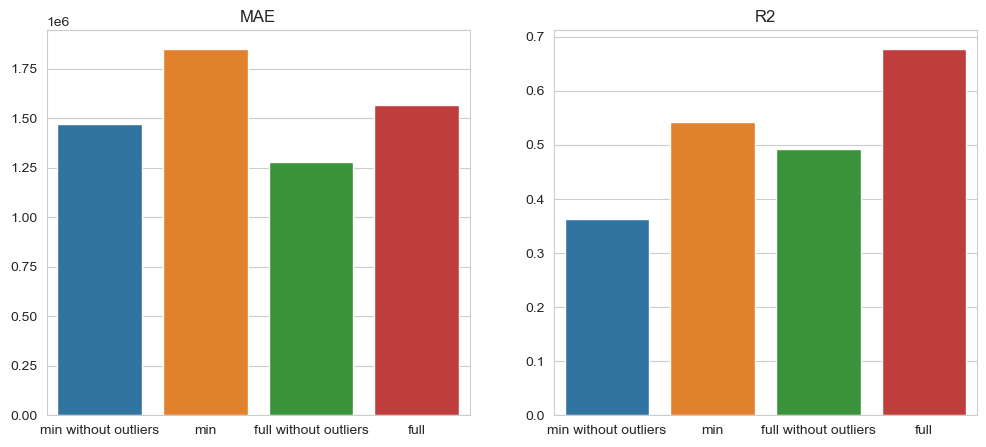

In [68]:
# Сравнение результатов на разных датасетах
plot_results(results_list[16:], datasets)

In [69]:
# Важность признаков в LightGBM
pd.DataFrame(
    {
        "feature": gbm.feature_name_,
        "importance": gbm.feature_importances_ / np.sum(gbm.feature_importances_),
    }
).sort_values(by="importance", ascending=False)

,feature,importance
2,street_id,0.462333
5,area,0.210000
8,metro_dist,0.068667
10,n_photos,0.067333
4,floor,0.049000
3,build_tech,0.037000
1,month,0.029333
6,rooms,0.024000
0,year,0.022000
7,balcon,0.012667


### Сравнение результатов

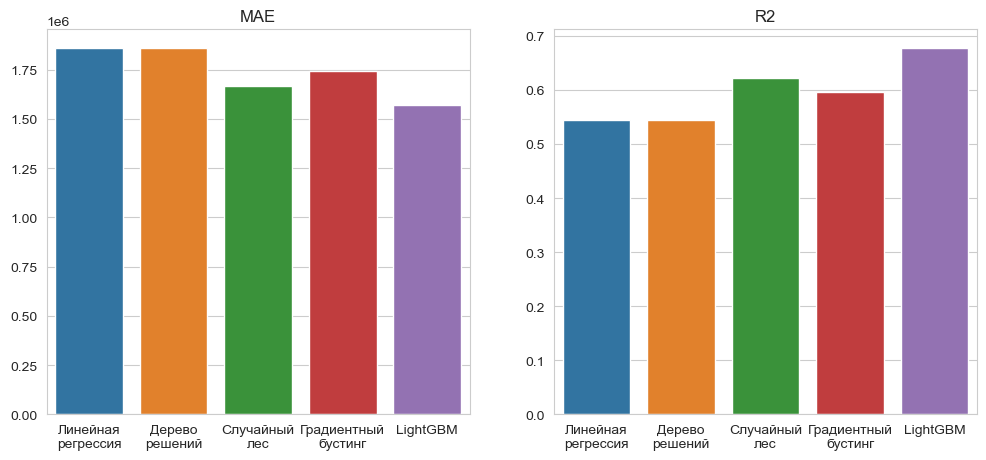

In [70]:
# Сравнение результатов разных моделей на большом датасете
plot_results(results_list[3::4], models)

Лучше всего "из коробки" показал себя LightGBM, на втором месте — случайный лес, на третьем — градиентный бустинг из scikit-learn. Также стоит отметить что все модели показывали лучшее качество на большом предобработанном датасете.

Поскольку LightGBM уже проявил себя и по качеству и по времени обучения (по сравнению с бустингом из sklearn) попробуем оптимизировать его гиперпараметры.

## Оптимизация гиперпараметров

Оптимизировать гиперпараметры будем с помощью библиотеки [optuna](https://optuna.org/), которой я буду пользоваться в первый раз, и вместо Scikit-learn API LightGBM-а я буду использовать стандартный [Python API](https://lightgbm.readthedocs.io/en/latest/Python-API.html) для интереса дополнительных возможностей, в частности для указания какие признаки являются закодированными категориальными, а ещё так будет проще обучать уже оптимизироанный LightBGM

In [71]:
# Функция, реализующая задачу оптимизации
def objective(trial: optuna.trial.Trial):
    # Создание датасета
    target = data_preprocessed["price"]
    df = data_preprocessed.drop(columns=["price"])

    train_x, valid_x, train_y, valid_y = train_test_split(
        df, target, test_size=0.1, random_state=42
    )
    # Закодированные категориальные признаки
    cat_features = ["street_id", "build_tech", "g_lift"] + [
        f"kw{i}" for i in range(1, 14)
    ]
    dtrain = lgb.Dataset(
        train_x, label=train_y, feature_name="auto", categorical_feature=cat_features
    )

    # Параметры для оптимизации
    param = {
        "objective": "regression",
        "metric": "mae",
        "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
        "verbosity": -1,
        "seed": 42,
    }
    num_boost_round = trial.suggest_int("num_iterations", 100, 1500)

    # Модель для оптимизации и целевая метрика
    trial_gbm = lgb.train(param, dtrain, num_boost_round=num_boost_round)
    preds = trial_gbm.predict(valid_x)
    return mean_absolute_error(valid_y, preds)

In [72]:
%%time
# Процесс оптимизации
study = optuna.create_study(study_name="LightGBM optimization", direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-05-10 14:29:53,485] A new study created in memory with name: LightGBM optimization
[I 2024-05-10 14:30:05,924] Trial 0 finished with value: 1313868.2665501302 and parameters: {'boosting': 'rf', 'learning_rate': 0.02194388166097921, 'num_leaves': 234, 'bagging_fraction': 0.9844262823104988, 'feature_fraction': 0.5798413939804206, 'lambda_l1': 0.19448806423520867, 'lambda_l2': 9.32115160398207, 'num_iterations': 1008}. Best is trial 0 with value: 1313868.2665501302.
[I 2024-05-10 14:30:09,207] Trial 1 finished with value: 1784507.4029850853 and parameters: {'boosting': 'rf', 'learning_rate': 0.07918571781665433, 'num_leaves': 158, 'bagging_fraction': 0.5809778779244126, 'feature_fraction': 0.32552758427826545, 'lambda_l1': 9.161299522918336, 'lambda_l2': 7.2243312248038265, 'num_iterations': 590}. Best is trial 0 with value: 1313868.2665501302.
[I 2024-05-10 14:30:12,262] Trial 2 finished with value: 688291.6962226484 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.032065

CPU times: total: 2h 9min 59s
Wall time: 13min 9s


По своему опыту могу сказать, что GridCVSearch из sklearn переберал бы гиперпараметры гораздо дольше.

In [73]:
# Лучшее значение метрики с указанием номера испытания, на котором она была достигнута
study.best_trial.number, study.best_trial.value

(73, 669558.6143189304)

In [74]:
# Лучшие значения параметров
study.best_params

{'boosting': 'gbdt',
 'learning_rate': 0.015744670703635867,
 'num_leaves': 99,
 'bagging_fraction': 0.4228242209572071,
 'feature_fraction': 0.5968686520157775,
 'lambda_l1': 9.357339415453406,
 'lambda_l2': 0.38695930764155884,
 'num_iterations': 978}

In [75]:
# Обучение лучшего регрессора
target = data_preprocessed["price"]
df = data_preprocessed.drop(columns=["price"])

train_x, valid_x, train_y, valid_y = train_test_split(
    df, target, test_size=0.1, random_state=42
)
cat_features = ["street_id", "build_tech", "g_lift"] + [f"kw{i}" for i in range(1, 14)]
dtrain = lgb.Dataset(
    train_x, label=train_y, feature_name="auto", categorical_feature=cat_features
)


best_params = study.best_params
num_iter = best_params.pop("num_iterations")

best_gbm = lgb.train(best_params, dtrain, num_boost_round=num_iter)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 23
[LightGBM] [Info] Start training from score 5132266.388889


In [76]:
# Значения метрик
preds = best_gbm.predict(valid_x)

best_result = {
    "MAE": mean_absolute_error(valid_y, preds),
    "R2": r2_score(valid_y, preds),
}
results_list.append(best_result)
results_list[-1]

{'MAE': 670655.4665541338, 'R2': 0.8765783635254469}

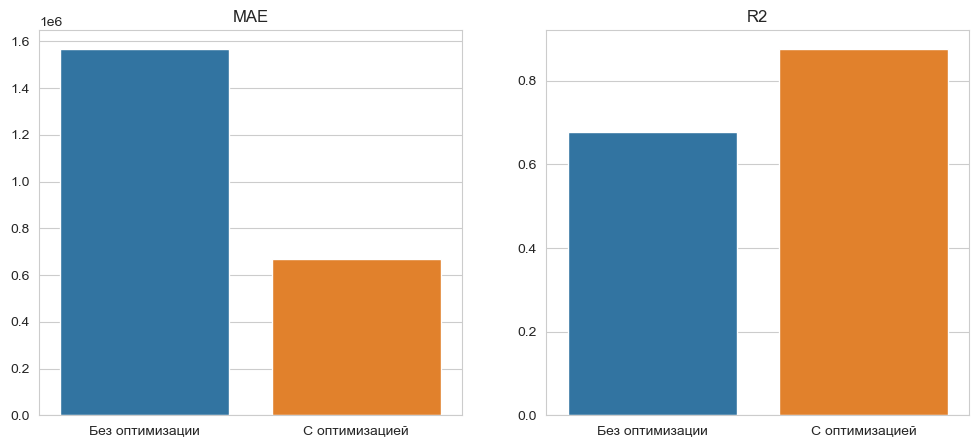

In [77]:
# Сравнение результатов
plot_results(results_list[-2:], ["Без оптимизации", "С оптимизацией"])

Оптимизация гиперпараметров помогла уменьшить MAE LightGBM более чем в два раза!

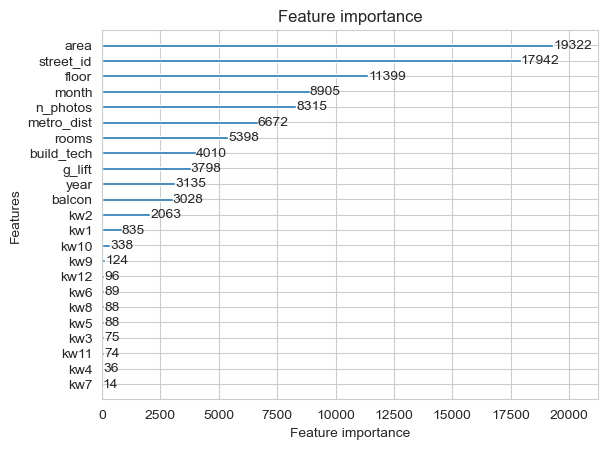

In [78]:
# Важность признаков в оптимизированном LightGBM
lgb.plot_importance(best_gbm)
plt.show()

## Submission

In [79]:
# Загрузка тестового датасета
test = pd.read_csv("data/test.csv")

test.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,459,NaN,1,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,344,1.0,10,52,2,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,100002,2012-3,585,0.0,4,54,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,494,NaN,2,52,2,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,622,1.0,9,60,3,1,15.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Предобработка тестового датасета
test_prepocessed = preprocess(test)

In [81]:
# Предсказания на теством датасете
test_id = test.id
test_pred = best_gbm.predict(test_prepocessed)

submission = pd.DataFrame({"id": test_id, "price": test_pred})

submission.to_csv("submission.csv", index=False)

## Итог

Ансамблевые модели, такие как случайный лес и градиентный бустинг, могут отлично справляться в тех случаях, где простые модели справляются плохо. Однако лучше всего они себя раскрывают, если подобрать правильные гиперпараметры, что удобно делать с помощью таких библиотек как optuna. 

Также стоит обратить внимание на другие реализации градиентного бустинга такие, как LightGBM и CatBoost. Они позволяют удобно работать с категориальными признаками, а также быстрее работают.